In [2]:
import numpy as np
import argparse
import pandas as pd
import glob
import datetime
import matplotlib.pyplot as plt
import act
import os
import sys
sys.path.append('/home/elilouis/sublimationofsnow')
import sosutils
from tempfile import TemporaryDirectory
import numpy as np
import seaborn as sns
import geopy
import geopandas as gpd
from shapely import geometry
import contextily as ctx

In [17]:

# # User Inputs

# +
USERNAME = os.getenv("ARM_USERNAME")
TOKEN = os.getenv("ARM_TOKEN")
SAIL_DATA_STREAM = 'gucdlrhiM1.b1'
SNR_THRESHOLD = 0.008
DOWNVALLEY_XSECTION_DISTANCE = 1500
RANGE_AVERAGING_DISTANCE = 100
VALLEY_PLANE_AZIMUTH = 129 # points down valley
sector_scan_hour = 21 # for an example plot of sector scans
sail_dl_pt = geometry.Point(-106.987900,38.956160)
kettle_ponds_pt = geometry.Point(-106.973006, 38.942005)



# date=(datetime.datetime.today() - datetime.timedelta(days=2)).strftime("%Y-%m-%d")
date = "2023-01-27"
downvalley_distance = DOWNVALLEY_XSECTION_DISTANCE

In [18]:


startdate = date
enddate = date

with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(USERNAME, TOKEN, SAIL_DATA_STREAM, startdate, enddate, output=temp_dir)
    dl_rhi_files = glob.glob(''.join([temp_dir, '/', SAIL_DATA_STREAM,'*cdf']))
    print(len(dl_rhi_files))
    dl_rhi = act.io.armfiles.read_netcdf(dl_rhi_files)
# -

# # Data preprocessing

src_rhi = dl_rhi.to_dataframe().reset_index()
src_rhi['time'] = src_rhi['time'].dt.tz_localize('UTC').dt.tz_convert('US/Mountain')
src_rhi['date'] = src_rhi['time'].dt.date
# RHI: convert polar coordinates to rectangular coords with the radar at (0,0)
src_rhi['x'] = src_rhi['range']*np.cos(np.deg2rad(src_rhi['elevation']))
src_rhi['z'] = src_rhi['range']*np.sin(np.deg2rad(src_rhi['elevation']))
src_rhi = src_rhi.set_index(['time', 'range'])

# Filter with SNR
src_rhi['SNR'] = src_rhi['intensity'] - 1
src_rhi.loc[src_rhi.eval(f'SNR < {SNR_THRESHOLD}'), 'radial_velocity'] = np.nan

[DOWNLOADING] gucdlrhiM1.b1.20230127.000118.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.000308.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.000508.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.003118.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.010117.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.010309.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.010508.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.013118.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.020118.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.020309.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.020508.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.023118.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.030117.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.030309.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.030507.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.033118.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.040117.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.040309.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.040508.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.043118.cdf
[DOWNLOADING] gucdlrhiM1.b1.20230127.050

/tmp/ipykernel_173886/1103931271.py:42: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (azimuth, rhi_sector_scan) in enumerate(src.query('range < 2000').groupby(["azimuth"])):


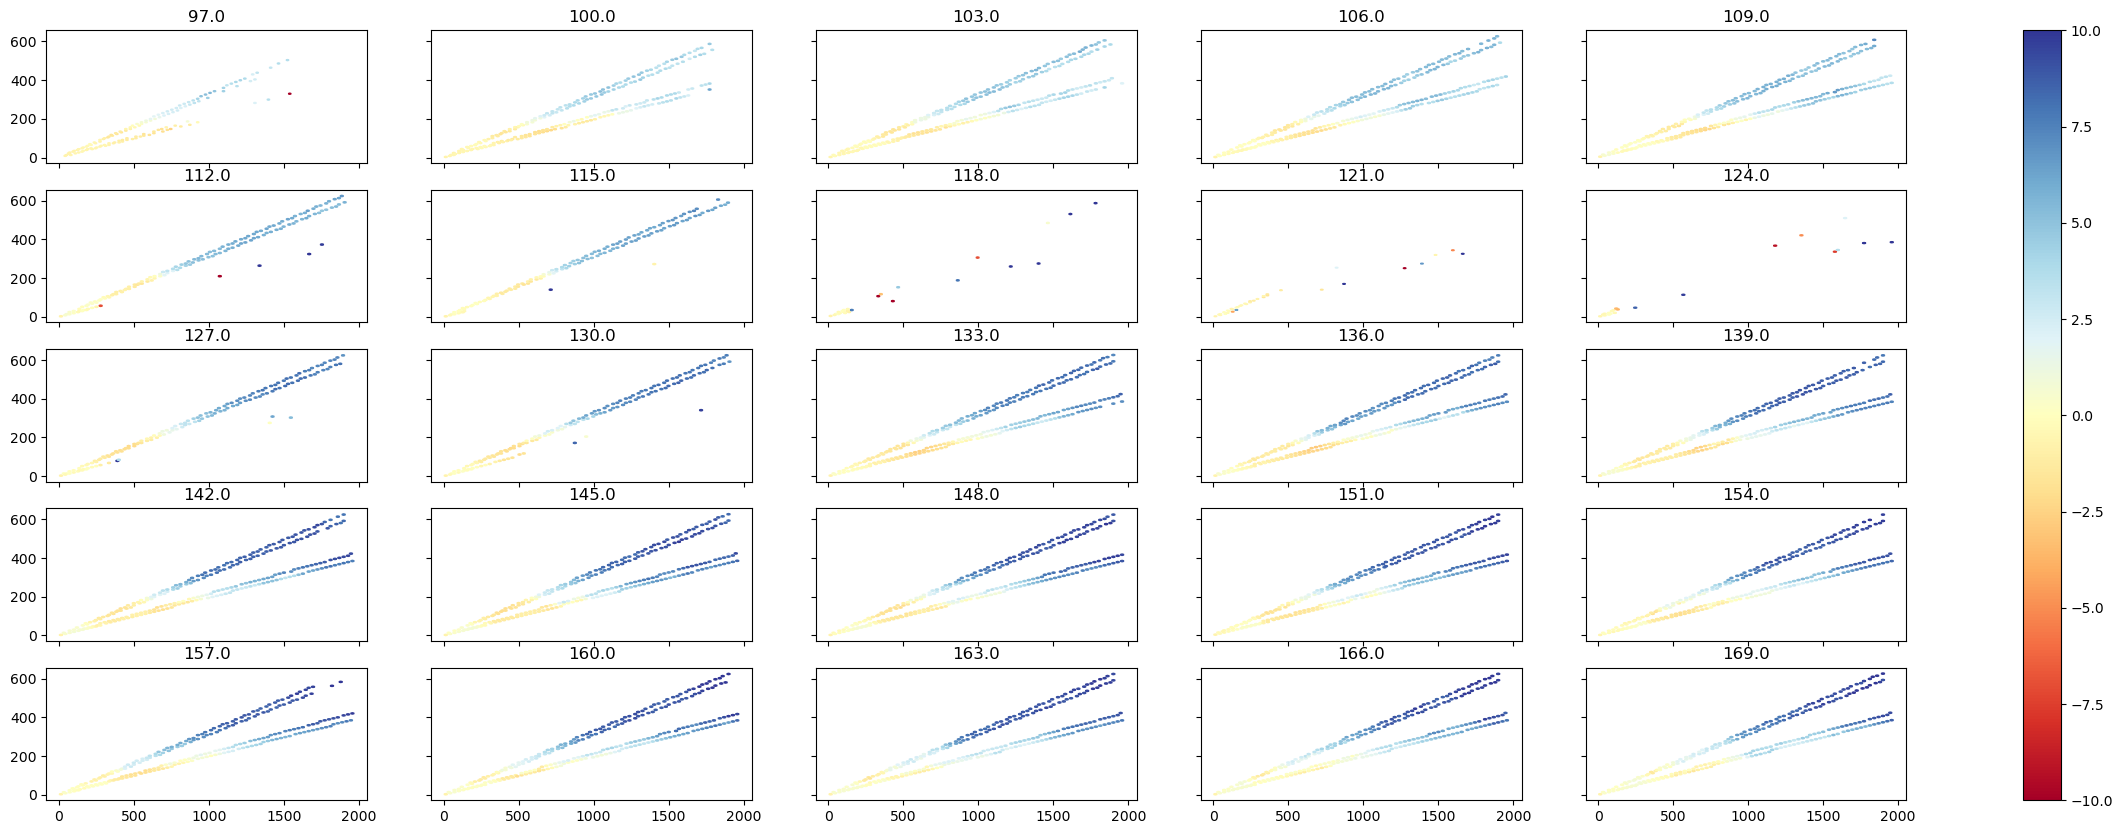

In [19]:


# # Examine RHI Scans

# 330˚ RHI-half:              01:17 --> 02:51
#
# 130˚ RHI-half:              03:09 --> 04:44
#
# 60˚ RHI-full:               05:13 --> 08:14
#
# Volume scan, 
# azi. 97-16˚9, elev. 6-31˚   31:18 --> 43

src_rhi['hour'] = src_rhi.index.get_level_values(0).hour
src_rhi['minute'] = src_rhi.index.get_level_values(0).minute

volume_df = src_rhi.query(
    f"hour == {sector_scan_hour}"
).query(
    "minute > 30"
)

np.linspace(97,169, 3)

azimuths = [ 97., 100., 103., 106., 109., 112., 115., 118., 121., 124., 127.,
    130., 133., 136., 139., 142., 145., 148., 151., 154., 157., 160.,
    163., 166., 169.]

# +
src = volume_df[volume_df.azimuth.isin(azimuths)]

# # Isolate to scan data near 12 and 18 degrees
src = src[(np.abs(src.elevation - 12) <= 1) | (np.abs(src.elevation - 18) <= 1)]

fig, axes = plt.subplots(
        5, 
        5, 
        figsize=(30,10),
        sharex=True, sharey=True
    )

hexplot = None
axes_list = axes.flatten()
for i, (azimuth, rhi_sector_scan) in enumerate(src.query('range < 2000').groupby(["azimuth"])):
    ax = axes_list[i]
    hexplot = ax.hexbin(rhi_sector_scan['x'], rhi_sector_scan['z'], C=rhi_sector_scan['radial_velocity'], cmap='RdYlBu', clim=(-10, 10))
    ax.set_title(f'{azimuth}')
    
fig.colorbar(hexplot, ax=axes.ravel().tolist())

/tmp/ipykernel_173886/3921923947.py:41: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (azimuth, rhi_sector_scan) in enumerate(src.query('range < 2000').groupby(["azimuth"])):


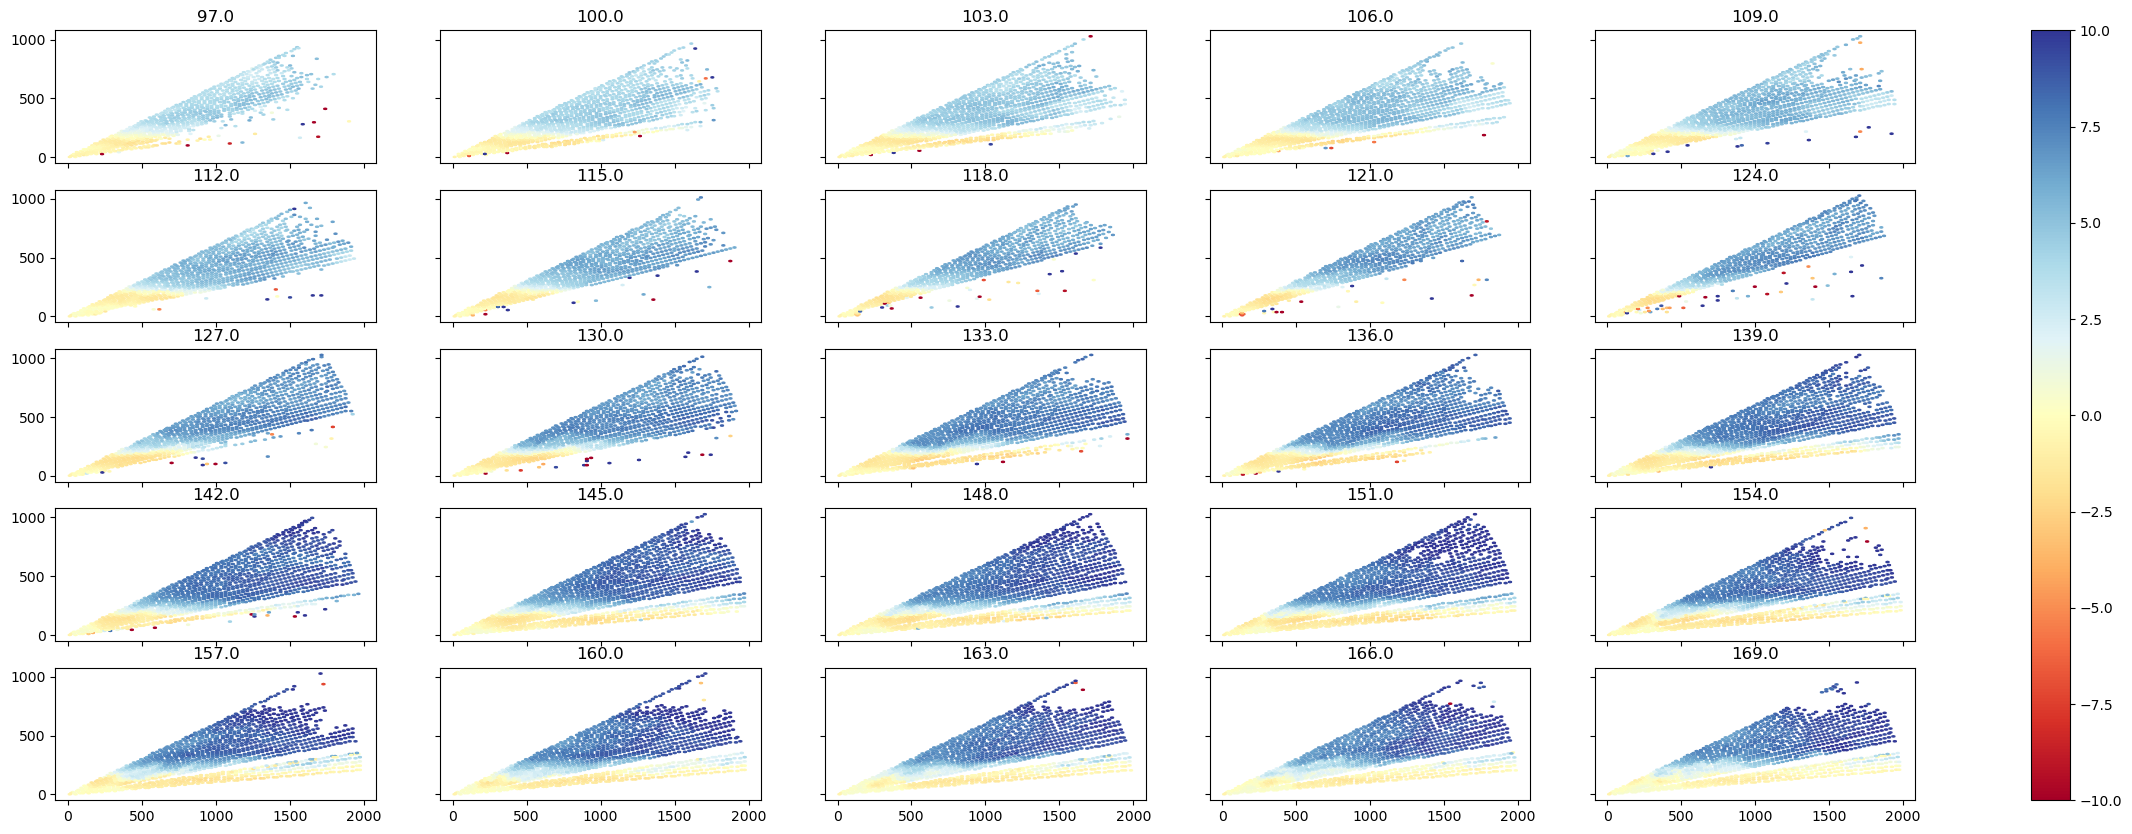

In [21]:


# # Examine RHI Scans

# 330˚ RHI-half:              01:17 --> 02:51
#
# 130˚ RHI-half:              03:09 --> 04:44
#
# 60˚ RHI-full:               05:13 --> 08:14
#
# Volume scan, 
# azi. 97-16˚9, elev. 6-31˚   31:18 --> 43

src_rhi['hour'] = src_rhi.index.get_level_values(0).hour
src_rhi['minute'] = src_rhi.index.get_level_values(0).minute

volume_df = src_rhi.query(
    f"hour == {sector_scan_hour}"
).query(
    "minute > 30"
)

np.linspace(97,169, 3)

azimuths = [ 97., 100., 103., 106., 109., 112., 115., 118., 121., 124., 127.,
    130., 133., 136., 139., 142., 145., 148., 151., 154., 157., 160.,
    163., 166., 169.]

# +
src = volume_df[volume_df.azimuth.isin(azimuths)]

src = src[(np.abs(src.elevation - 12) > 1) | (np.abs(src.elevation - 18) < 1)]

fig, axes = plt.subplots(
        5, 
        5, 
        figsize=(30,10),
        sharex=True, sharey=True
    )

hexplot = None
axes_list = axes.flatten()
for i, (azimuth, rhi_sector_scan) in enumerate(src.query('range < 2000').groupby(["azimuth"])):
    ax = axes_list[i]
    hexplot = ax.hexbin(rhi_sector_scan['x'], rhi_sector_scan['z'], C=rhi_sector_scan['radial_velocity'], cmap='RdYlBu', clim=(-10, 10))
    ax.set_title(f'{azimuth}')
    
fig.colorbar(hexplot, ax=axes.ravel().tolist())